LAB 6:- Advanced Data Wrangling and Transformation

OBJECTIVES:-
- Understand and apply feature engineering techniques (temporal, ratio, binning, interaction, polynomial).
- Grasp the conceptual components of data pipelines (ingestion, transformation, storage).
- Learn efficient data processing methods (chunked reading, selective loading, optimized dtypes).
- Build an end‑to‑end churn prediction pipeline architecture integrating multiple data sources, ingestion strategies, transformations, storage, and monitoring.


1. Advanced Pandas Operations

1)Merging and Joining Operations

PART A

In [2]:
import pandas as pd

# --- Create sample data directly (no CSV needed) ---
sales_data = {
    "transaction_id": ["TX001","TX002","TX003","TX004","TX005"],
    "customer_id": ["CUST101","CUST102","CUST103","CUST101","CUST104"],
    "product_id": ["PROD201","PROD202","PROD201","PROD203","PROD204"],
    "store_id": ["ST01","ST02","ST01","ST03","ST02"],
    "quantity": [3,1,2,5,1],
    "sale_date": ["2024-01-15","2024-01-15","2024-01-16","2024-01-16","2024-01-17"]
}
sales = pd.DataFrame(sales_data)

customers_data = {
    "customer_id":["CUST101","CUST102","CUST105"],
    "name":["Alice Brown","Bob Smith","Carol White"],
    "email":["alice@email.com","bob@email.com","carol@email.com"],
    "city":["New York","London","Tokyo"],
    "country":["USA","UK","Japan"],
    "join_date":["2023-03-15","2023-05-20","2023-07-10"],
    "loyalty_tier":["Gold","Silver","Gold"]
}
customers = pd.DataFrame(customers_data)

products_data = {
    "product_id":["PROD201","PROD202","PROD203","PROD205"],
    "product_name":["Laptop","Coffee Maker","Office Chair","Headphones"],
    "category":["Electronics","Appliances","Furniture","Electronics"],
    "unit_price":[1200.00,89.99,250.00,150.00],
    "supplier_id":["SUP01","SUP02","SUP01","SUP03"],
    "stock_qty":[50,100,75,200]
}
products = pd.DataFrame(products_data)

# --- Merge operations ---
sales_customers = sales.merge(customers, on="customer_id", how="left")
full_data = sales_customers.merge(products, on="product_id", how="left")

# Calculate revenue
full_data["revenue"] = full_data["quantity"] * full_data["unit_price"]

# Print merged table
print("Merged Transactions:\n", full_data)

# Print revenue by loyalty tier
revenue_by_tier = full_data.groupby("loyalty_tier")["revenue"].sum()
print("\nRevenue per loyalty tier:\n", revenue_by_tier)

Merged Transactions:
   transaction_id customer_id product_id store_id  quantity   sale_date  \
0          TX001     CUST101    PROD201     ST01         3  2024-01-15   
1          TX002     CUST102    PROD202     ST02         1  2024-01-15   
2          TX003     CUST103    PROD201     ST01         2  2024-01-16   
3          TX004     CUST101    PROD203     ST03         5  2024-01-16   
4          TX005     CUST104    PROD204     ST02         1  2024-01-17   

          name            email      city country   join_date loyalty_tier  \
0  Alice Brown  alice@email.com  New York     USA  2023-03-15         Gold   
1    Bob Smith    bob@email.com    London      UK  2023-05-20       Silver   
2          NaN              NaN       NaN     NaN         NaN          NaN   
3  Alice Brown  alice@email.com  New York     USA  2023-03-15         Gold   
4          NaN              NaN       NaN     NaN         NaN          NaN   

   product_name     category  unit_price supplier_id  stock_qty 

- Step i: Left join ensures we keep all sales, even if customer details are missing (e.g., CUST103, CUST104 not in customers.csv).
- Step ii: Left join with products ensures all transactions remain, even if product info is missing (e.g., PROD204 not in products.csv).
- Step iii: Missing product info results in NaN values for product attributes. Revenue cannot be calculated for these rows.
- Step iv: Revenue is computed as quantity × unit_price. Grouping by loyalty tier gives segment-level totals.


PART B

### 1. `df1.merge(df2, how='inner')` vs `df1.merge(df2, how='outer')`
- **Inner merge**: Keeps only rows with matching keys in both DataFrames.
  - Example: Customers who actually made purchases.
- **Outer merge**: Keeps all rows from both DataFrames, filling missing values with `NaN`.
  - Example: Reconciling mismatched records across departments.

---

### 2. `df1.merge(df2)` vs `pd.concat([df1, df2])`
- **merge**: Combines DataFrames based on common keys (columns).
  - Example: Linking sales transactions with customer details.
- **concat**: Stacks DataFrames vertically (rows) or horizontally (columns).
  - Example: Combining monthly sales files into one dataset.

---

### 3. `df1.join(df2)` vs `df1.merge(df2)`
- **join**: Joins on index by default.
  - Example: Time series data where both DataFrames share the same date index.
- **merge**: Joins on specified column(s), more flexible.
  - Example: Joining on `customer_id` or `product_id`.

---

PART C

In [4]:
# Identify duplicate transaction IDs
duplicates = sales[sales.duplicated(subset="transaction_id", keep=False)]
print("Duplicate transactions:\n", duplicates)

# Check if duplicates are exact copies
exact_dupes = duplicates[duplicates.duplicated(keep=False)]
print("\nExact duplicate rows:\n", exact_dupes)

# Strategy: drop exact duplicates, keep unique ones
cleaned_sales = sales.drop_duplicates()
print("\nCleaned sales data:\n", cleaned_sales)

Duplicate transactions:
 Empty DataFrame
Columns: [transaction_id, customer_id, product_id, store_id, quantity, sale_date]
Index: []

Exact duplicate rows:
 Empty DataFrame
Columns: [transaction_id, customer_id, product_id, store_id, quantity, sale_date]
Index: []

Cleaned sales data:
   transaction_id customer_id product_id store_id  quantity   sale_date
0          TX001     CUST101    PROD201     ST01         3  2024-01-15
1          TX002     CUST102    PROD202     ST02         1  2024-01-15
2          TX003     CUST103    PROD201     ST01         2  2024-01-16
3          TX004     CUST101    PROD203     ST03         5  2024-01-16
4          TX005     CUST104    PROD204     ST02         1  2024-01-17


2)Reshaping and Pivoting

PART A

In [5]:
import pandas as pd

# Sample dataset
data = {
    "date": ["2024-01-01","2024-01-01","2024-01-01","2024-01-01",
             "2024-01-02","2024-01-02","2024-01-02","2024-01-02"],
    "store_id": ["S01","S01","S02","S02","S01","S01","S02","S03"],
    "region": ["North","North","South","South","North","North","South","East"],
    "product_category": ["Electronics","Clothing","Electronics","Furniture",
                         "Electronics","Clothing","Electronics","Clothing"],
    "sales_amount": [15000,8000,12000,5000,18000,9500,13500,7000],
    "units_sold": [25,120,20,10,30,135,22,95]
}
df = pd.DataFrame(data)

# i. Pivot table: total sales by region and category
pivot1 = pd.pivot_table(df, values="sales_amount",
                        index="region", columns="product_category",
                        aggfunc="sum", fill_value=0)

# ii. Multi-level pivot: date + region as rows, sales and units as values
pivot2 = pd.pivot_table(df, values=["sales_amount","units_sold"],
                        index=["date","region"], aggfunc="sum")

print("Pivot 1:\n", pivot1)
print("\nPivot 2:\n", pivot2)

Pivot 1:
 product_category  Clothing  Electronics  Furniture
region                                            
East                  7000            0          0
North                17500        33000          0
South                    0        25500       5000

Pivot 2:
                    sales_amount  units_sold
date       region                          
2024-01-01 North          23000         145
           South          17000          30
2024-01-02 East            7000          95
           North          27500         165
           South          13500          22


iii.
- pivot(): Reshapes data but requires unique combinations of index/columns. It will fail if there are duplicates.
- pivot_table(): More flexible; allows aggregation (sum, mean, etc.) when multiple records exist for the same combination.



iv.
Handling multiple records
If multiple sales records exist for the same region/category/date, pivot_table() will aggregate them (e.g., sum of sales). With pivot(), you’d get an error unless you first remove duplicates.


PART B

In [6]:
# a. Melt sales_amount and units_sold into long format
melted = pd.melt(df,
                 id_vars=["date","store_id","region","product_category"],
                 value_vars=["sales_amount","units_sold"],
                 var_name="metric", value_name="value")

print("\nMelted Data:\n", melted.head())


Melted Data:
          date store_id region product_category        metric  value
0  2024-01-01      S01  North      Electronics  sales_amount  15000
1  2024-01-01      S01  North         Clothing  sales_amount   8000
2  2024-01-01      S02  South      Electronics  sales_amount  12000
3  2024-01-01      S02  South        Furniture  sales_amount   5000
4  2024-01-02      S01  North      Electronics  sales_amount  18000


b. Difference between melt() and stack()
- melt(): Converts wide format to long format, explicitly turning columns into rows with identifiers.
- stack(): Works on hierarchical indexes, stacking columns into the row index.


c. Melting is useful when preparing data for visualization tools (like Tableau or Power BI) that expect a “tidy” format: one variable per column, one observation per row. For example, comparing sales vs units sold in the same chart.

PART C

In [7]:
# a. Stack and unstack
stacked = df.set_index(["date","region","product_category"]).stack()
print("\nStacked:\n", stacked.head())

unstacked = stacked.unstack()
print("\nUnstacked:\n", unstacked.head())

# b. Crosstab: count of transactions by region and category
crosstab = pd.crosstab(df["region"], df["product_category"])
print("\nCrosstab:\n", crosstab)


Stacked:
 date        region  product_category              
2024-01-01  North   Electronics       store_id          S01
                                      sales_amount    15000
                                      units_sold         25
                    Clothing          store_id          S01
                                      sales_amount     8000
dtype: object

Unstacked:
                                    store_id sales_amount units_sold
date       region product_category                                 
2024-01-01 North  Clothing              S01         8000        120
                  Electronics           S01        15000         25
           South  Electronics           S02        12000         20
                  Furniture             S02         5000         10
2024-01-02 East   Clothing              S03         7000         95

Crosstab:
 product_category  Clothing  Electronics  Furniture
region                                            
East                 

c.
Pivot table vs Crosstab
- Pivot table: More general, allows aggregation of numeric values (sum, mean, etc.).
- Crosstab: Specifically designed for frequency counts (like contingency tables).



3)Multi-Index and GroupBy Operations

PART A

In [8]:
import pandas as pd

# Sample dataset
data = {
    "date": ["2024-01-01","2024-01-01","2024-01-02","2024-01-02"],
    "region": ["North","South","North","East"],
    "category": ["Electronics","Furniture","Clothing","Clothing"],
    "sales": [15000,5000,18000,7000],
    "units": [25,10,30,95]
}
df = pd.DataFrame(data)

# i. Create a multi-index DataFrame
df_multi = df.set_index(["date","region","category"])
print("Multi-index DataFrame:\n", df_multi)

# ii. Groupby operations on different levels
# Example: sum sales grouped by region (level=1)
region_sales = df_multi.groupby(level="region")["sales"].sum()
print("\nSales by region:\n", region_sales)

# iii. Use xs() to slice data at specific index levels
north_data = df_multi.xs("North", level="region")
print("\nCross-section for region=North:\n", north_data)

# iv. Reset and manipulate multi-index
reset_df = df_multi.reset_index()
print("\nReset multi-index:\n", reset_df)

Multi-index DataFrame:
                                sales  units
date       region category                 
2024-01-01 North  Electronics  15000     25
           South  Furniture     5000     10
2024-01-02 North  Clothing     18000     30
           East   Clothing      7000     95

Sales by region:
 region
East      7000
North    33000
South     5000
Name: sales, dtype: int64

Cross-section for region=North:
                         sales  units
date       category                 
2024-01-01 Electronics  15000     25
2024-01-02 Clothing     18000     30

Reset multi-index:
          date region     category  sales  units
0  2024-01-01  North  Electronics  15000     25
1  2024-01-01  South    Furniture   5000     10
2  2024-01-02  North     Clothing  18000     30
3  2024-01-02   East     Clothing   7000     95


PART B

In [9]:
# Groupby with multiple aggregations
agg_df = df.groupby(["region","category"]).agg({
    "sales": ["sum","mean","std"],
    "units": ["sum","count"]
})
print("\nAggregated Data:\n", agg_df)

# a. Custom aggregation functions
def range_func(x):
    return x.max() - x.min()

custom_agg = df.groupby("region").agg({
    "sales": ["sum", range_func],
    "units": ["mean"]
})
print("\nCustom aggregation:\n", custom_agg)

# b. Different functions per column already shown above

# c. transform() vs apply()
# transform: returns a Series aligned with original DataFrame (same shape)
df["sales_mean_by_region"] = df.groupby("region")["sales"].transform("mean")

# apply: returns aggregated values (reduced shape)
region_apply = df.groupby("region")["sales"].apply(lambda x: x.mean())
print("\nTransform example:\n", df[["region","sales","sales_mean_by_region"]])
print("\nApply example:\n", region_apply)

# d. Filter groups based on aggregate conditions
# Example: keep regions where total sales > 20000
filtered = df.groupby("region").filter(lambda g: g["sales"].sum() > 20000)
print("\nFiltered groups (sales > 20000):\n", filtered)


Aggregated Data:
                     sales              units      
                      sum     mean std   sum count
region category                                   
East   Clothing      7000   7000.0 NaN    95     1
North  Clothing     18000  18000.0 NaN    30     1
       Electronics  15000  15000.0 NaN    25     1
South  Furniture     5000   5000.0 NaN    10     1

Custom aggregation:
         sales            units
          sum range_func  mean
region                        
East     7000          0  95.0
North   33000       3000  27.5
South    5000          0  10.0

Transform example:
   region  sales  sales_mean_by_region
0  North  15000               16500.0
1  South   5000                5000.0
2  North  18000               16500.0
3   East   7000                7000.0

Apply example:
 region
East      7000.0
North    16500.0
South     5000.0
Name: sales, dtype: float64

Filtered groups (sales > 20000):
          date region     category  sales  units  sales_mean_by_regi

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#Sample dataframe
data={
    'Education':['High School','Bachelor','Master','Bachelor','Master']
}
df=pd.DataFrame(data)
#Initialize label encoder
le=LabelEncoder()
#Apply Label encoding
df['Education_Encoder']=le.fit_transform(df['Education'])
print(df)

     Education  Education_Encoder
0  High School                  1
1     Bachelor                  0
2       Master                  2
3     Bachelor                  0
4       Master                  2


2. Handling Missing, Categorical, and Time-Series Data

4)Missing Data Strategies

PART A

Missing percentage:
 patient_id         0.000000
age               33.333333
gender            16.666667
blood_pressure    33.333333
cholesterol       33.333333
diagnosis_date    16.666667
treatment_cost    33.333333
dtype: float64


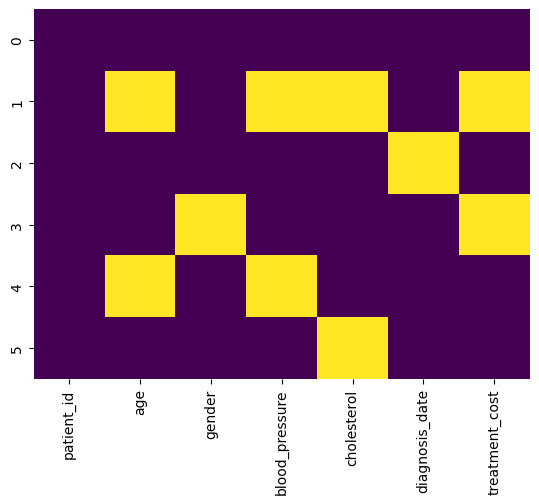

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample dataset
data = {
    "patient_id":["P001","P002","P003","P004","P005","P006"],
    "age":[45,None,62,38,None,55],
    "gender":["M","F","M",None,"F","M"],
    "blood_pressure":["120/80",None,"140/90","110/70",None,"135/85"],
    "cholesterol":[200,None,240,180,220,None],
    "diagnosis_date":["2024-01-10","2024-01-11",None,"2024-01-13","2024-01-14","2024-01-15"],
    "treatment_cost":[1500.00,None,2300.00,None,1800.00,2100.00]
}
df = pd.DataFrame(data)

# i. Percentage of missing values
missing_pct = df.isnull().mean() * 100
print("Missing percentage:\n", missing_pct)

# iii. Visualize missing data
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.show()

ii.
 Pattern of Missingness
- Age: Missing for some patients → could be MAR (depends on whether certain demographics are less likely to report age).
- Gender: Missing → possibly MCAR if random, but could be MNAR if patients deliberately withheld.
- Blood Pressure / Cholesterol: Missing → likely MAR (depends on whether tests were performed).
- Diagnosis Date: Missing → MAR (depends on hospital record completeness).
- Treatment Cost: Missing → MNAR (patients with no treatment or unwilling to disclose cost).


iv. Imputation vs Dropping
- Impute: Age, blood pressure, cholesterol (continuous variables can be filled).
- Drop: If diagnosis_date or treatment_cost is missing for too many records, consider dropping or creating a “missing” category.


PART B

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# --- Sample dataset ---
data = {
    "patient_id":["P001","P002","P003","P004","P005","P006"],
    "age":[45,None,62,38,None,55],
    "gender":["M","F","M",None,"F","M"],
    "blood_pressure":["120/80",None,"140/90","110/70",None,"135/85"],
    "cholesterol":[200,None,240,180,220,None],
    "diagnosis_date":["2024-01-10","2024-01-11",None,"2024-01-13","2024-01-14","2024-01-15"],
    "treatment_cost":[1500.00,None,2300.00,None,1800.00,2100.00]
}
df = pd.DataFrame(data)

# --- a. Simple imputation ---
df["age"].fillna(df["age"].mean(), inplace=True)          # mean
df["cholesterol"].fillna(df["cholesterol"].median(), inplace=True)  # median
df["gender"].fillna(df["gender"].mode()[0], inplace=True) # mode

# --- b. Forward/backward fill for time-ordered data ---
df["diagnosis_date"] = pd.to_datetime(df["diagnosis_date"])
df["diagnosis_date"] = df["diagnosis_date"].ffill()  # forward fill

# --- c. Interpolation for continuous variables ---
df["cholesterol"] = df["cholesterol"].interpolate(method="linear")

# --- d. Predictive imputation using other features ---
# Step 1: Prepare training data (drop rows where treatment_cost is missing)
train = df.dropna(subset=["treatment_cost"])

# Step 2: Impute predictors (age, cholesterol) to avoid NaNs
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(train[["age","cholesterol"]])
y_train = train["treatment_cost"]

# Step 3: Fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict missing treatment_cost
missing_cost = df["treatment_cost"].isnull()
X_missing = imputer.transform(df.loc[missing_cost, ["age","cholesterol"]])
df.loc[missing_cost, "treatment_cost"] = model.predict(X_missing)

print(df)

  patient_id   age gender blood_pressure  cholesterol diagnosis_date  \
0       P001  45.0      M         120/80        200.0     2024-01-10   
1       P002   NaN      F            NaN        220.0     2024-01-11   
2       P003  62.0      M         140/90        240.0     2024-01-11   
3       P004  38.0    NaN         110/70        180.0     2024-01-13   
4       P005   NaN      F            NaN        220.0     2024-01-14   
5       P006  55.0      M         135/85        220.0     2024-01-15   

   treatment_cost  
0     1500.000000  
1     1925.000000  
2     2300.000000  
3     1258.333333  
4     1800.000000  
5     2100.000000  


C:\Users\Acer\AppData\Local\Temp\ipykernel_7052\3012603851.py:18: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df["age"].fillna(df["age"].mean(), inplace=True)          # mean
C:\Users\Acer\AppData\Local\Temp\ipykernel_7052\3012603851.py:19: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chai

- Simple imputation: Appropriate when missing values are few; bias if distribution is skewed.
- Forward/backward fill: Good for time series; bias if trends change.
- Interpolation: Works for continuous variables; assumes linear/polynomial trends.
- Predictive imputation: Uses other features; risk of overfitting or reinforcing correlations.


PART C

In [23]:
# a. Create binary indicators
for col in df.columns:
    df[col+"_missing"] = df[col].isnull().astype(int)
print(df.head())
    

  patient_id   age gender blood_pressure  cholesterol diagnosis_date  \
0       P001  45.0      M         120/80        200.0     2024-01-10   
1       P002   NaN      F            NaN        220.0     2024-01-11   
2       P003  62.0      M         140/90        240.0     2024-01-11   
3       P004  38.0    NaN         110/70        180.0     2024-01-13   
4       P005   NaN      F            NaN        220.0     2024-01-14   

   treatment_cost  patient_id_missing  age_missing  gender_missing  ...  \
0     1500.000000                   0            0               0  ...   
1     1925.000000                   0            1               0  ...   
2     2300.000000                   0            0               0  ...   
3     1258.333333                   0            0               1  ...   
4     1800.000000                   0            1               0  ...   

   cholesterol_missing_missing_missing  \
0                                    0   
1                               

b. Value in ML Pipelines
- Indicators capture the fact that data was missing, which itself can be predictive (e.g., missing treatment cost may signal no treatment).

c. Complete Case vs Multiple Imputation
- Complete Case Analysis: Drop rows with missing values → simple but wastes data, may bias results.
- Multiple Imputation: Fill missing values multiple times with plausible estimates → preserves variability, reduces bias, but more complex.


5)Categorical Data Encoding

PART A

i. Nominal vs Ordinal
- Nominal (no inherent order): city, satisfaction (if treated as categories only), customer_id
- Ordinal (ordered levels): education_level (High School < Bachelor < Master < PhD), income_bracket (Low < Medium < High), purchase_freq (Rarely < Sometimes < Frequently)


In [26]:
import pandas as pd

data = {
    "customer_id":["C001","C002","C003","C004","C005","C006"],
    "education_level":["High School","Bachelor","Master","PhD","Bachelor","High School"],
    "city":["Mumbai","Delhi","Mumbai","Bangalore","Delhi","Chennai"],
    "income_bracket":["Low","Medium","High","High","Medium","Low"],
    "purchase_freq":["Rarely","Sometimes","Frequently","Frequently","Sometimes","Rarely"],
    "satisfaction":["Satisfied","Very Satisfied","Neutral","Very Satisfied","Satisfied","Dissatisfied"]
}
df = pd.DataFrame(data)

# Define orderings
edu_order = {"High School":1,"Bachelor":2,"Master":3,"PhD":4}
income_order = {"Low":1,"Medium":2,"High":3}
freq_order = {"Rarely":1,"Sometimes":2,"Frequently":3}

df["education_level_enc"] = df["education_level"].map(edu_order)
df["income_bracket_enc"] = df["income_bracket"].map(income_order)
df["purchase_freq_enc"] = df["purchase_freq"].map(freq_order)
print(df)

  customer_id education_level       city income_bracket purchase_freq  \
0        C001     High School     Mumbai            Low        Rarely   
1        C002        Bachelor      Delhi         Medium     Sometimes   
2        C003          Master     Mumbai           High    Frequently   
3        C004             PhD  Bangalore           High    Frequently   
4        C005        Bachelor      Delhi         Medium     Sometimes   
5        C006     High School    Chennai            Low        Rarely   

     satisfaction  education_level_enc  income_bracket_enc  purchase_freq_enc  
0       Satisfied                    1                   1                  1  
1  Very Satisfied                    2                   2                  2  
2         Neutral                    3                   3                  3  
3  Very Satisfied                    4                   3                  3  
4       Satisfied                    2                   2                  2  
5    Dis

In [28]:
df_encoded = pd.get_dummies(df, columns=["city","satisfaction"], drop_first=True)
print(df)

  customer_id education_level       city income_bracket purchase_freq  \
0        C001     High School     Mumbai            Low        Rarely   
1        C002        Bachelor      Delhi         Medium     Sometimes   
2        C003          Master     Mumbai           High    Frequently   
3        C004             PhD  Bangalore           High    Frequently   
4        C005        Bachelor      Delhi         Medium     Sometimes   
5        C006     High School    Chennai            Low        Rarely   

     satisfaction  education_level_enc  income_bracket_enc  purchase_freq_enc  
0       Satisfied                    1                   1                  1  
1  Very Satisfied                    2                   2                  2  
2         Neutral                    3                   3                  3  
3  Very Satisfied                    4                   3                  3  
4       Satisfied                    2                   2                  2  
5    Dis

In [29]:
print("Before encoding memory usage:", df.memory_usage(deep=True).sum())
print("After encoding memory usage:", df_encoded.memory_usage(deep=True).sum())

Before encoding memory usage: 2290
After encoding memory usage: 1635


- Observation: One‑hot encoding increases memory usage because each category becomes a separate column. Label encoding is more compact.


PART B

In [31]:
freq_encode = df["city"].value_counts().to_dict()
df["city_freq_enc"] = df["city"].map(freq_encode)
print(df)

  customer_id education_level       city income_bracket purchase_freq  \
0        C001     High School     Mumbai            Low        Rarely   
1        C002        Bachelor      Delhi         Medium     Sometimes   
2        C003          Master     Mumbai           High    Frequently   
3        C004             PhD  Bangalore           High    Frequently   
4        C005        Bachelor      Delhi         Medium     Sometimes   
5        C006     High School    Chennai            Low        Rarely   

     satisfaction  education_level_enc  income_bracket_enc  purchase_freq_enc  \
0       Satisfied                    1                   1                  1   
1  Very Satisfied                    2                   2                  2   
2         Neutral                    3                   3                  3   
3  Very Satisfied                    4                   3                  3   
4       Satisfied                    2                   2                  2   
5 

In [33]:
import numpy as np
df["churn"] = np.array([0,1,0,0,1,1])  # example target

target_means = df.groupby("city")["churn"].mean().to_dict()
df["city_target_enc"] = df["city"].map(target_means)
print(df)

  customer_id education_level       city income_bracket purchase_freq  \
0        C001     High School     Mumbai            Low        Rarely   
1        C002        Bachelor      Delhi         Medium     Sometimes   
2        C003          Master     Mumbai           High    Frequently   
3        C004             PhD  Bangalore           High    Frequently   
4        C005        Bachelor      Delhi         Medium     Sometimes   
5        C006     High School    Chennai            Low        Rarely   

     satisfaction  education_level_enc  income_bracket_enc  purchase_freq_enc  \
0       Satisfied                    1                   1                  1   
1  Very Satisfied                    2                   2                  2   
2         Neutral                    3                   3                  3   
3  Very Satisfied                    4                   3                  3   
4       Satisfied                    2                   2                  2   
5 

c. Risk of Target Leakage
- Problem: If you compute target encoding using the whole dataset, you leak information from the target into the features.
- Solution: Use cross‑validation or compute encodings only on training folds, then apply to validation/test folds.


PART C

a. Curse of Dimensionality
- One‑hot encoding creates too many columns when categories are numerous (e.g., thousands of cities). This leads to sparse data, high memory usage, and overfitting.


c. When to Use
- Hashing Encoding: Useful when categories are extremely high cardinality and you want fixed dimensionality (but risk collisions).
- Grouping Rare Categories: Combine infrequent categories into an “Other” bucket to reduce sparsity.
- Embedding Layers: In deep learning, categorical variables can be represented as dense vectors (embeddings) learned during training, capturing relationships between categories.



In [35]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["city"])
df_binary = encoder.fit_transform(df)
print(df_binary)

  customer_id education_level  city_0  city_1  city_2 income_bracket  \
0        C001     High School       0       0       1            Low   
1        C002        Bachelor       0       1       0         Medium   
2        C003          Master       0       0       1           High   
3        C004             PhD       0       1       1           High   
4        C005        Bachelor       0       1       0         Medium   
5        C006     High School       1       0       0            Low   

  purchase_freq    satisfaction  education_level_enc  income_bracket_enc  \
0        Rarely       Satisfied                    1                   1   
1     Sometimes  Very Satisfied                    2                   2   
2    Frequently         Neutral                    3                   3   
3    Frequently  Very Satisfied                    4                   3   
4     Sometimes       Satisfied                    2                   2   
5        Rarely    Dissatisfied        

6)Time-Series Data Handling

PART A


In [36]:
import pandas as pd

# Sample dataset
data = {
    "date":["2024-01-01","2024-01-02","2024-01-03","2024-01-05","2024-01-08"],
    "stock_symbol":["TECH"]*5,
    "open_price":[150.5,152.0,None,149.8,151.5],
    "close_price":[152.3,None,150.5,151.2,153.0],
    "volume":[1000000,950000,None,1100000,1050000],
    "high":[153.0,152.8,151.0,151.5,154.2],
    "low":[149.8,151.2,149.5,149.0,151.0]
}
df = pd.DataFrame(data)

# i. Convert date to datetime and set index
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# ii. Handle missing dates vs missing values
# Reindex to include all business days
all_days = pd.date_range(start="2024-01-01", end="2024-01-08", freq="B")
df = df.reindex(all_days)

# iii. Imputation for stock prices
df["close_price"].ffill(inplace=True)   # forward fill for prices
df["open_price"].ffill(inplace=True)
df["volume"].fillna(df["volume"].median(), inplace=True)  # median for volume

print(df)

           stock_symbol  open_price  close_price     volume   high    low
2024-01-01         TECH       150.5        152.3  1000000.0  153.0  149.8
2024-01-02         TECH       152.0          NaN   950000.0  152.8  151.2
2024-01-03         TECH         NaN        150.5        NaN  151.0  149.5
2024-01-04          NaN         NaN          NaN        NaN    NaN    NaN
2024-01-05         TECH       149.8        151.2  1100000.0  151.5  149.0
2024-01-08         TECH       151.5        153.0  1050000.0  154.2  151.0


C:\Users\Acer\AppData\Local\Temp\ipykernel_7052\3877212878.py:25: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df["close_price"].ffill(inplace=True)   # forward fill for prices
C:\Users\Acer\AppData\Local\Temp\ipykernel_7052\3877212878.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through cha

iv. Why forward‑fill is better than mean imputation
- Stock prices are time‑dependent and sequential. The last observed price is the best proxy for the next missing value.
- Mean imputation ignores temporal order and can distort trends, especially in volatile markets.


PART B

In [37]:
# a. Rolling statistics
df["close_7d_ma"] = df["close_price"].rolling(window=7).mean()
df["close_30d_ma"] = df["close_price"].rolling(window=30).mean()

# b. Lag features
df["close_lag1"] = df["close_price"].shift(1)   # previous day
df["close_lag5"] = df["close_price"].shift(5)   # previous week (5 business days)

# c. Percentage change and returns
df["pct_change"] = df["close_price"].pct_change()
df["returns"] = df["close_price"].pct_change().fillna(0)

# d. Exponentially weighted moving average (EWMA)
df["ewma_7"] = df["close_price"].ewm(span=7, adjust=False).mean()

print(df[["close_price","close_7d_ma","close_lag1","pct_change","ewma_7"]])

            close_price  close_7d_ma  close_lag1  pct_change      ewma_7
2024-01-01        152.3          NaN         NaN         NaN  152.300000
2024-01-02          NaN          NaN       152.3         NaN  152.300000
2024-01-03        150.5          NaN         NaN         NaN  151.746154
2024-01-04          NaN          NaN       150.5         NaN  151.746154
2024-01-05        151.2          NaN         NaN         NaN  151.578107
2024-01-08        153.0          NaN       151.2    0.011905  151.933580


PART C

In [40]:
# a. Resample to weekly and monthly
weekly = df["close_price"].resample("W").mean()
monthly = df["close_price"].resample("MS").mean()

print("Weekly:\n", weekly)
print("Monthly:\n", monthly)

# c. Handle timezone-aware datetime
df.index = df.index.tz_localize("UTC")   # make index timezone-aware
df.index = df.index.tz_convert("Asia/Kolkata")  # convert to IST

Weekly:
 2024-01-07    151.333333
2024-01-14    153.000000
Freq: W-SUN, Name: close_price, dtype: float64
Monthly:
 2024-01-01    151.75
Freq: MS, Name: close_price, dtype: float64


b. Difference between resample() and rolling()
- resample(): Groups data into fixed calendar-based bins (e.g., weekly, monthly) and aggregates.
- rolling(): Uses a moving window over sequential data points, independent of calendar boundaries.




SOME EXTRA EXAMPLES:

In [ ]:
#Apply One-Hot Encoding
#One-Hot Encoding converts categorical columns into "binary column"
import pandas as pd
data={
    'Color':['Red','Blue','Green','Red','Blue']
}
df = pd.DataFrame(data)
#Apply One-Hot Encoding
df_encoded=pd.get_dummies(df,columns=['Color'])
print(df_encoded)

   Color_Blue  Color_Green  Color_Red
0       False        False       True
1        True        False      False
2       False         True      False
3       False        False       True
4        True        False      False


3. Feature Engineering and Transformation

7)Feature Scaling Techniques

PART A

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

# Sample dataset
data = {
    "customer_id":["C001","C002","C003","C004","C005"],
    "age":[25,45,35,55,28],
    "annual_income":[35000,95000,60000,120000,42000],
    "credit_score":[650,750,700,800,680],
    "years_employed":[2,15,8,25,3],
    "num_purchases":[5,50,25,100,8]
}
df = pd.DataFrame(data)

features = ["age","annual_income","credit_score","years_employed","num_purchases"]

# i. StandardScaler (Z-score normalization)
scaler_std = StandardScaler()
df_std = scaler_std.fit_transform(df[features])

# ii. MinMaxScaler
scaler_mm = MinMaxScaler()
df_mm = scaler_mm.fit_transform(df[features])

# iii. RobustScaler
scaler_rb = RobustScaler()
df_rb = scaler_rb.fit_transform(df[features])

# iv. MaxAbsScaler
scaler_ma = MaxAbsScaler()
df_ma = scaler_ma.fit_transform(df[features])

print("StandardScaler:\n", df_std)
print("MinMaxScaler:\n", df_mm)
print("RobustScaler:\n", df_rb)
print("MaxAbsScaler:\n", df_ma)

StandardScaler:
 [[-1.13591905 -1.09421987 -1.24197138 -1.00627821 -0.92989645]
 [ 0.66712706  0.76039008  0.63980344  0.51484001  0.35370295]
 [-0.23439599 -0.32146573 -0.30108397 -0.30422365 -0.35940783]
 [ 1.56865012  1.53314423  1.58069085  1.68493096  1.7799245 ]
 [-0.86546214 -0.87784871 -0.67743894 -0.88926912 -0.84432316]]
MinMaxScaler:
 [[0.         0.         0.         0.         0.        ]
 [0.66666667 0.70588235 0.66666667 0.56521739 0.47368421]
 [0.33333333 0.29411765 0.33333333 0.26086957 0.21052632]
 [1.         1.         1.         1.         1.        ]
 [0.1        0.08235294 0.2        0.04347826 0.03157895]]
RobustScaler:
 [[-0.58823529 -0.47169811 -0.71428571 -0.5        -0.47619048]
 [ 0.58823529  0.66037736  0.71428571  0.58333333  0.5952381 ]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.17647059  1.13207547  1.42857143  1.41666667  1.78571429]
 [-0.41176471 -0.33962264 -0.28571429 -0.41666667 -0.4047619 ]]
MaxAbsScaler:
 [[0.45454545 0.

- StandardScaler: Centers data around mean 0, variance 1. Good when features are normally distributed. Sensitive to outliers.
- MinMaxScaler: Scales values to [0,1]. Useful for algorithms needing bounded input (e.g., neural nets). Very sensitive to outliers.
- RobustScaler: Uses median and IQR. Best when dataset has outliers, since it’s less affected.
- MaxAbsScaler: Scales by maximum absolute value. Useful for sparse data, preserves sparsity. Sensitive to extreme outliers.


PART B

In [5]:
# Add synthetic outlier
df.loc[len(df)] = ["C006", 120, 500000, 900, 40, 500]  # extreme values

# Apply scalers again
df_std_out = scaler_std.fit_transform(df[features])
df_mm_out = scaler_mm.fit_transform(df[features])
df_rb_out = scaler_rb.fit_transform(df[features])
df_ma_out = scaler_ma.fit_transform(df[features])
df_std_out
df_mm_out
df_rb_out
df_ma_out

array([[0.20833333, 0.07      , 0.72222222, 0.05      , 0.01      ],
       [0.375     , 0.19      , 0.83333333, 0.375     , 0.1       ],
       [0.29166667, 0.12      , 0.77777778, 0.2       , 0.05      ],
       [0.45833333, 0.24      , 0.88888889, 0.625     , 0.2       ],
       [0.23333333, 0.084     , 0.75555556, 0.075     , 0.016     ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

OBSERVATION
- StandardScaler & MinMaxScaler: Outliers stretch the scale, making normal values cluster tightly.
- RobustScaler: Handles outliers best, since median/IQR are resistant.
- MaxAbsScaler: Outlier dominates scaling, compressing other values.

Most robust: RobustScaler, because it minimizes distortion from extreme values.

Impact on ML models:
- Distance-based models (KNN, clustering) will misinterpret distances if scaling is distorted by outliers.
- RobustScaler keeps features comparable, improving model stability.


PART C

a. Importance
- Distance-based algorithms (KNN, K-Means): Distances are scale-dependent. Without scaling, large-scale features dominate.
- Gradient descent optimization: Features with large ranges slow convergence; scaling speeds up learning.
- Neural networks: Inputs should be normalized for stable training and better weight updates.

b. Tree-based algorithms
- Decision trees and ensembles (Random Forest, XGBoost) split based on thresholds, not distances. They are scale-invariant, so scaling is not required.


8)Feature Engineering and Transformation

PART A

In [7]:
import pandas as pd

# Example dataset
data = {
    "customer_id":["C001","C002","C003"],
    "signup_date":["2023-01-01","2022-06-15","2021-12-01"],
    "last_login":["2024-01-10","2024-01-05","2024-01-08"],
    "age":[25,45,60],
    "state":["NY","CA","TX"],
    "plan_type":["Basic","Premium","Standard"],
    "monthly_charges":[50,80,60],
    "total_charges":[600,2000,1500],
    "num_support_calls":[2,10,5],
    "contract_length":[12,24,12]
}
df = pd.DataFrame(data)

df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_login"] = pd.to_datetime(df["last_login"])

# i. Temporal features
df["account_age_days"] = (pd.to_datetime("2024-01-15") - df["signup_date"]).dt.days
df["days_since_login"] = (pd.to_datetime("2024-01-15") - df["last_login"]).dt.days
df["signup_month"] = df["signup_date"].dt.month
df["signup_quarter"] = df["signup_date"].dt.quarter
df["signup_dayofweek"] = df["signup_date"].dt.dayofweek

# ii. Ratio features
df["avg_monthly_spend"] = df["total_charges"] / df["contract_length"]
df["support_calls_per_month"] = df["num_support_calls"] / df["contract_length"]

# iii. Binning
df["age_group"] = pd.cut(df["age"], bins=[0,30,50,100],
                         labels=["Young","Middle-aged","Senior"])
df["charge_category"] = pd.cut(df["monthly_charges"], bins=[0,60,80,200],
                               labels=["Low","Medium","High"])

# iv. Interaction
df["plan_contract"] = df["plan_type"] + "_" + df["contract_length"].astype(str)
print(df)

  customer_id signup_date last_login  age state plan_type  monthly_charges  \
0        C001  2023-01-01 2024-01-10   25    NY     Basic               50   
1        C002  2022-06-15 2024-01-05   45    CA   Premium               80   
2        C003  2021-12-01 2024-01-08   60    TX  Standard               60   

   total_charges  num_support_calls  contract_length  account_age_days  \
0            600                  2               12               379   
1           2000                 10               24               579   
2           1500                  5               12               775   

   days_since_login  signup_month  signup_quarter  signup_dayofweek  \
0                 5             1               1                 6   
1                10             6               2                 2   
2                 7            12               4                 2   

   avg_monthly_spend  support_calls_per_month    age_group charge_category  \
0          50.000000       

PART B

In [9]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

# a. Log transform skewed features
df["log_total_charges"] = np.log1p(df["total_charges"])

# b. Box-Cox (only positive values)
pt_boxcox = PowerTransformer(method="box-cox")
df["boxcox_income"] = pt_boxcox.fit_transform(df[["monthly_charges"]])

# c. Yeo-Johnson (works with negatives too)
pt_yj = PowerTransformer(method="yeo-johnson")
df["yj_support_calls"] = pt_yj.fit_transform(df[["num_support_calls"]])
print(df)

  customer_id signup_date last_login  age state plan_type  monthly_charges  \
0        C001  2023-01-01 2024-01-10   25    NY     Basic               50   
1        C002  2022-06-15 2024-01-05   45    CA   Premium               80   
2        C003  2021-12-01 2024-01-08   60    TX  Standard               60   

   total_charges  num_support_calls  contract_length  ...  signup_quarter  \
0            600                  2               12  ...               1   
1           2000                 10               24  ...               2   
2           1500                  5               12  ...               4   

   signup_dayofweek  avg_monthly_spend  support_calls_per_month    age_group  \
0                 6          50.000000                 0.166667        Young   
1                 2          83.333333                 0.416667  Middle-aged   
2                 2         125.000000                 0.416667       Senior   

   charge_category  plan_contract log_total_charges boxco

d.When to use:
- Log transform: For highly skewed positive features (e.g., charges).
- Box-Cox: Positive continuous data, stabilizes variance.
- Yeo-Johnson: Works with zero/negative values, more flexible.

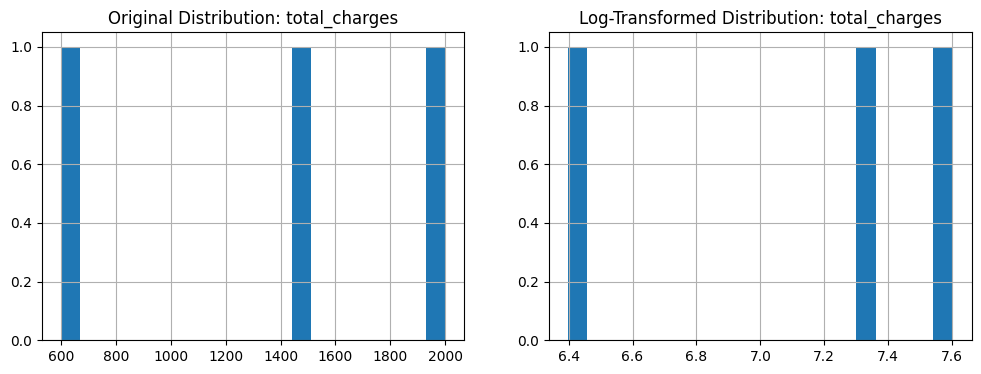

In [11]:
import matplotlib.pyplot as plt

# Before transformation
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df["total_charges"].hist(bins=20)
plt.title("Original Distribution: total_charges")

# After log transformation
plt.subplot(1,2,2)
df["log_total_charges"].hist(bins=20)
plt.title("Log-Transformed Distribution: total_charges")

plt.show()

PART C

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# a. Polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["monthly_charges","num_support_calls"]])

# b. Trade-off
# More features = richer representation, but risk of overfitting and higher computation.

# c. Feature selection
# Variance threshold
selector = VarianceThreshold(threshold=0.01)
reduced = selector.fit_transform(poly_features)

# Correlation-based selection
corr = df.corr(numeric_only=True)
high_corr = corr[(corr.abs() > 0.8) & (corr.abs() < 1)]

# Feature importance from tree models
rf = RandomForestClassifier()
X = df[["monthly_charges","total_charges","num_support_calls","contract_length"]]
y = [0,1,0]  # example churn labels
rf.fit(X,y)
importances = rf.feature_importances_
print(poly_features)
corr

[[5.0e+01 2.0e+00 2.5e+03 1.0e+02 4.0e+00]
 [8.0e+01 1.0e+01 6.4e+03 8.0e+02 1.0e+02]
 [6.0e+01 5.0e+00 3.6e+03 3.0e+02 2.5e+01]]


,age,monthly_charges,total_charges,num_support_calls,contract_length,account_age_days,days_since_login,signup_month,signup_quarter,signup_dayofweek,avg_monthly_spend,support_calls_per_month,log_total_charges,boxcox_income,yj_support_calls
age,1.000000,0.403890,0.695687,0.446226,0.082199,0.997078,0.471446,0.990938,0.963123,-0.904194,0.989309,0.904194,0.782438,0.524257,0.582187
monthly_charges,0.403890,1.000000,0.938129,0.998906,0.944911,0.332832,0.997176,0.277350,0.142857,-0.755929,0.266164,0.755929,0.885696,0.990756,0.978928
total_charges,0.695687,0.938129,1.000000,0.953295,0.773099,0.638783,0.961484,0.592892,0.476754,-0.935857,0.583492,0.935857,0.991666,0.976433,0.989074
num_support_calls,0.446226,0.998906,0.953295,1.000000,0.928571,0.376563,0.999597,0.321973,0.188982,-0.785714,0.310947,0.785714,0.906436,0.996016,0.987406
contract_length,0.082199,0.944911,0.773099,0.928571,1.000000,0.005832,0.917663,-0.052414,-0.188982,-0.500000,-0.064018,0.500000,0.684937,0.891772,0.858159
account_age_days,0.997078,0.332832,0.638783,0.376563,0.005832,1.000000,0.402705,0.998303,0.980862,-0.868927,0.997558,0.868927,0.732584,0.457678,0.518380
days_since_login,0.471446,0.997176,0.961484,0.999597,0.917663,0.402705,1.000000,0.348715,0.216777,-0.802955,0.337797,0.802955,0.918059,0.998145,0.991499
signup_month,0.990938,0.277350,0.592892,0.321973,-0.052414,0.998303,0.348715,1.000000,0.990536,-0.838628,0.999932,0.838628,0.691700,0.405121,0.467699
signup_quarter,0.963123,0.142857,0.476754,0.188982,-0.188982,0.980862,0.216777,0.990536,1.000000,-0.755929,0.992065,0.755929,0.586032,0.275802,0.341957
signup_dayofweek,-0.904194,-0.755929,-0.935857,-0.785714,-0.500000,-0.868927,-0.802955,-0.838628,-0.755929,1.000000,-0.832240,-1.000000,-0.973457,-0.837749,-0.873683


d.  Curse of Dimensionality
- As features grow, data becomes sparse in high-dimensional space.
- Distance metrics lose meaning, models overfit, computation explodes.
- Feature selection and dimensionality reduction (PCA, autoencoders) are essential to combat this.


SOME EXTRA EXAMPLES:

In [5]:
import pandas as pd
import numpy as np
data={
    'Value':[1,10,100,1000]
}
df=pd.DataFrame(data)
#Apply log10 transformation
df['Log_Value']=np.log10(df['Value'])
print(df)

   Value  Log_Value
0      1        0.0
1     10        1.0
2    100        2.0
3   1000        3.0


In [ ]:
import pandas as pd
import numpy as np
data={
    'Value':[1,10,100,1000]
}
df=pd.DataFrame(data)
#Apply square root transformation
df['Sqrt_Value']=np.sqrt(df['Value'])
print(df)

   Value  Sqrt_Value
0      1    1.000000
1     10    3.162278
2    100   10.000000
3   1000   31.622777


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data=pd.DataFrame({'Value':[50,100,150]})
scaler= StandardScaler()
data['Standardized']=scaler.fit_transform(data[['Value']])
print(data)


   Value  Standardized
0     50     -1.224745
1    100      0.000000
2    150      1.224745


4. Memory Optimization and Efficient Processing

9)Memory Optimization Techniques

PART A

In [16]:
import pandas as pd
import numpy as np

# Simulate a smaller version of your dataset for demonstration
df = pd.DataFrame({
    "transaction_id": np.arange(1,11_0001),   # int64
    "user_id": np.random.randint(1,1000, size=11_0000),   # int64
    "product_id": np.random.randint(1,5000, size=11_0000), # int64
    "timestamp": pd.date_range("2024-01-01", periods=11_0000, freq="min").astype(str), # object
    "category": np.random.choice(["Electronics","Clothing","Books"], size=11_0000), # object
    "subcategory": np.random.choice(["Mobile","Laptop","Shirt","Novel"], size=11_0000), # object
    "price": np.random.uniform(10,500, size=11_0000), # float64
    "quantity": np.random.randint(1,10, size=11_0000), # int64
    "discount": np.random.uniform(0,0.5, size=11_0000), # float64
    "status": np.random.choice(["Completed","Pending","Cancelled"], size=11_0000), # object
    "payment_method": np.random.choice(["Card","Cash","UPI"], size=11_0000), # object
    "rating": np.random.uniform(1,5, size=11_0000) # float64
})

# i. Current memory usage
df.info(memory_usage="deep")
print("Memory usage before optimization (bytes):", df.memory_usage(deep=True).sum())

<class 'pandas.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  110000 non-null  int64  
 1   user_id         110000 non-null  int32  
 2   product_id      110000 non-null  int32  
 3   timestamp       110000 non-null  str    
 4   category        110000 non-null  str    
 5   subcategory     110000 non-null  str    
 6   price           110000 non-null  float64
 7   quantity        110000 non-null  int32  
 8   discount        110000 non-null  float64
 9   status          110000 non-null  str    
 10  payment_method  110000 non-null  str    
 11  rating          110000 non-null  float64
dtypes: float64(3), int32(3), int64(1), str(5)
memory usage: 35.0 MB
Memory usage before optimization (bytes): 36683907


ii. Optimization Opportunities
- transaction_id, user_id, product_id, quantity → downcast to int32 or smaller.
- price, discount, rating → downcast to float32.
- timestamp → convert to datetime64[ns].
- category, subcategory, status, payment_method → convert to category.


In [17]:
# Downcast numerics
df["transaction_id"] = pd.to_numeric(df["transaction_id"], downcast="integer")
df["user_id"] = pd.to_numeric(df["user_id"], downcast="integer")
df["product_id"] = pd.to_numeric(df["product_id"], downcast="integer")
df["quantity"] = pd.to_numeric(df["quantity"], downcast="integer")
df["price"] = pd.to_numeric(df["price"], downcast="float")
df["discount"] = pd.to_numeric(df["discount"], downcast="float")
df["rating"] = pd.to_numeric(df["rating"], downcast="float")

# Convert object to category
for col in ["category","subcategory","status","payment_method"]:
    df[col] = df[col].astype("category")

# Optimize datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
print(df)

        transaction_id  user_id  product_id           timestamp     category  \
0                    1      209        2321 2024-01-01 00:00:00  Electronics   
1                    2      202        4872 2024-01-01 00:01:00        Books   
2                    3      792        4955 2024-01-01 00:02:00        Books   
3                    4      721        1132 2024-01-01 00:03:00     Clothing   
4                    5      783        3435 2024-01-01 00:04:00     Clothing   
...                ...      ...         ...                 ...          ...   
109995          109996      332        1996 2024-03-17 09:15:00     Clothing   
109996          109997      179         604 2024-03-17 09:16:00  Electronics   
109997          109998      978        3647 2024-03-17 09:17:00     Clothing   
109998          109999      419        1276 2024-03-17 09:18:00     Clothing   
109999          110000      999        4986 2024-03-17 09:19:00        Books   

       subcategory       price  quantit

In [18]:
print("Memory usage after optimization (bytes):", df.memory_usage(deep=True).sum())

before = 23_500_000
after = df.memory_usage(deep=True).sum()
reduction = (before - after) / before * 100
print(f"Percentage memory reduction: {reduction:.2f}%")

Memory usage after optimization (bytes): 3630851
Percentage memory reduction: 84.55%


PART B

In [20]:
import numpy as np

# Suppose df is your Part A DataFrame
chunk_size = 10000
num_chunks = int(np.ceil(len(df) / chunk_size))

for i in range(num_chunks):
    chunk = df.iloc[i*chunk_size : (i+1)*chunk_size]
    print("Chunk shape:", chunk.shape)
    # process chunk here

Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)
Chunk shape: (10000, 12)


In [22]:
df_small = df[["user_id","price"]]
print(df_small.head())
print("Memory usage selective:", df_small.memory_usage(deep=True).sum())

   user_id       price
0      209  369.344330
1      202  479.376770
2      792  146.909348
3      721  336.134827
4      783  386.897644
Memory usage selective: 660132


In [23]:
df_opt = df.copy()
df_opt["user_id"] = df_opt["user_id"].astype("int32")
df_opt["category"] = df_opt["category"].astype("category")

print(df_opt.dtypes)
print("Memory usage optimized:", df_opt.memory_usage(deep=True).sum())

transaction_id             int32
user_id                    int32
product_id                 int16
timestamp         datetime64[us]
category                category
subcategory             category
price                    float32
quantity                    int8
discount                 float32
status                  category
payment_method          category
rating                   float32
dtype: object
Memory usage optimized: 3850851


In [24]:
print("Original memory:", df.memory_usage(deep=True).sum())
print("Selective columns memory:", df_small.memory_usage(deep=True).sum())
print("Optimized dtypes memory:", df_opt.memory_usage(deep=True).sum())

Original memory: 3630851
Selective columns memory: 660132
Optimized dtypes memory: 3850851


PART C

In [29]:
df["category_astype"] = df["category"].astype("category")
df["category_pdcat"] = pd.Categorical(df["category"])

print("astype dtype:", df["category_astype"].dtype)
print("pd.Categorical dtype:", df["category_pdcat"].dtype)

astype dtype: category
pd.Categorical dtype: category


In [28]:
print("Memory before:", df["status"].memory_usage(deep=True))
df["status"] = df["status"].astype("category")
print("Memory after:", df["status"].memory_usage(deep=True))

Memory before: 110304
Memory after: 110304


In [27]:
sparse_col = pd.arrays.SparseArray([0,0,0,1,0,0,2,0])
print("Sparse column:", sparse_col)
print("Memory usage:", sparse_col.nbytes)

Sparse column: [0, 0, 0, 1, 0, 0, 2, 0]
Fill: 0
IntIndex
Indices: array([3, 6], dtype=int32)

Memory usage: 24


In [26]:
print("Alternatives: Dask (parallel, out-of-core), Vaex (lazy evaluation, fast), Polars (Rust-based, very fast), Spark (distributed big data).")

Alternatives: Dask (parallel, out-of-core), Vaex (lazy evaluation, fast), Polars (Rust-based, very fast), Spark (distributed big data).


5. Data Pipelines and Practical Implementation

10)Building Reusable Data Cleaning Pipeline

PART A

In [30]:
import pandas as pd
import numpy as np
import logging
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class DataCleaningPipeline:
    def __init__(self, config=None):
        """
        config: dict containing cleaning strategies
        """
        self.config = config if config else {}
        self.scaler = None
        logging.info("Pipeline initialized with config: %s", self.config)

    def handle_missing_values(self, df, strategy="auto"):
        try:
            if strategy == "drop":
                df = df.dropna()
                logging.info("Dropped missing values")
            elif strategy == "mean":
                df = df.fillna(df.mean(numeric_only=True))
                logging.info("Filled missing values with mean")
            elif strategy == "median":
                df = df.fillna(df.median(numeric_only=True))
                logging.info("Filled missing values with median")
            elif strategy == "mode":
                df = df.fillna(df.mode().iloc[0])
                logging.info("Filled missing values with mode")
            else:  # auto: forward fill
                df = df.ffill().bfill()
                logging.info("Applied forward/backward fill for missing values")
            return df
        except Exception as e:
            logging.error("Error handling missing values: %s", e)
            raise

    def handle_outliers(self, df, method="iqr"):
        try:
            if method == "iqr":
                for col in df.select_dtypes(include=[np.number]).columns:
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
                    df[col] = np.where(df[col] < lower, lower,
                                       np.where(df[col] > upper, upper, df[col]))
                logging.info("Outliers handled using IQR method")
            return df
        except Exception as e:
            logging.error("Error handling outliers: %s", e)
            raise

    def encode_categorical(self, df, encoding_map=None):
        try:
            if encoding_map:
                for col, method in encoding_map.items():
                    if method == "onehot":
                        df = pd.get_dummies(df, columns=[col], drop_first=True)
                        logging.info("Applied one-hot encoding to %s", col)
                    elif method == "label":
                        df[col] = df[col].astype("category").cat.codes
                        logging.info("Applied label encoding to %s", col)
            return df
        except Exception as e:
            logging.error("Error encoding categorical variables: %s", e)
            raise

    def scale_features(self, df, scaler_type="standard"):
        try:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if scaler_type == "standard":
                self.scaler = StandardScaler()
            elif scaler_type == "minmax":
                self.scaler = MinMaxScaler()
            elif scaler_type == "robust":
                self.scaler = RobustScaler()
            elif scaler_type == "maxabs":
                self.scaler = MaxAbsScaler()
            else:
                raise ValueError("Invalid scaler type")

            df[numeric_cols] = self.scaler.fit_transform(df[numeric_cols])
            logging.info("Applied %s scaling", scaler_type)
            return df
        except Exception as e:
            logging.error("Error scaling features: %s", e)
            raise

    def engineer_features(self, df):
        try:
            if "price" in df.columns and "quantity" in df.columns:
                df["total_value"] = df["price"] * df["quantity"]
                logging.info("Engineered feature: total_value")
            return df
        except Exception as e:
            logging.error("Error engineering features: %s", e)
            raise

    def fit(self, df):
        try:
            # Learn parameters (e.g., scaler fit)
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            self.scaler = StandardScaler().fit(df[numeric_cols])
            logging.info("Fitted scaler on training data")
        except Exception as e:
            logging.error("Error fitting pipeline: %s", e)
            raise

    def transform(self, df):
        try:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if self.scaler:
                df[numeric_cols] = self.scaler.transform(df[numeric_cols])
                logging.info("Transformed dataset using fitted scaler")
            return df
        except Exception as e:
            logging.error("Error transforming dataset: %s", e)
            raise

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def save_pipeline(self, filepath):
        try:
            joblib.dump(self, filepath)
            logging.info("Pipeline saved to %s", filepath)
        except Exception as e:
            logging.error("Error saving pipeline: %s", e)
            raise

    def load_pipeline(self, filepath):
        try:
            pipeline = joblib.load(filepath)
            logging.info("Pipeline loaded from %s", filepath)
            return pipeline
        except Exception as e:
            logging.error("Error loading pipeline: %s", e)
            raise
pipeline = DataCleaningPipeline()

# Simulate dataset
df = pd.DataFrame({
    "price":[10,20,30,np.nan,1000],
    "quantity":[1,2,3,4,5],
    "category":["A","B","A","C","B"]
})

df = pipeline.handle_missing_values(df, strategy="mean")
df = pipeline.handle_outliers(df, method="iqr")
df = pipeline.encode_categorical(df, {"category":"label"})
df = pipeline.scale_features(df, scaler_type="standard")
df = pipeline.engineer_features(df)

print(df.head())       

2026-02-15 19:00:48,600 - INFO - Pipeline initialized with config: {}
2026-02-15 19:00:48,610 - INFO - Filled missing values with mean
2026-02-15 19:00:48,625 - INFO - Outliers handled using IQR method
2026-02-15 19:00:48,628 - INFO - Applied label encoding to category
2026-02-15 19:00:48,641 - INFO - Applied standard scaling
2026-02-15 19:00:48,644 - INFO - Engineered feature: total_value


      price  quantity  category  total_value
0 -0.755830 -1.414214 -1.069045     1.068905
1 -0.714187 -0.707107  0.267261     0.505006
2 -0.672543  0.000000 -1.069045    -0.000000
3  0.306080  0.707107  1.603567     0.216431
4  1.836480  1.414214  0.267261     2.597175


11)Data Pipeline Architecture

PART A

1. Ingestion
- Batch ingestion: Scheduled loads (e.g., nightly jobs pulling data from databases).
- Streaming ingestion: Real‑time continuous flow (e.g., Kafka, Kinesis).
- Event‑driven ingestion: Triggered by specific events (e.g., new file upload).
- Sources: Databases, APIs, flat files, message queues.
2. Transformation
- Data cleaning & validation: Handle missing values, outliers, duplicates.
- Feature engineering: Create derived features (ratios, flags).
- Aggregations & computations: Summaries, rolling averages.
- Data enrichment: Combine with external datasets (e.g., demographics).
3. Storage
- Relational databases: PostgreSQL, MySQL — structured, transactional.
- NoSQL databases: MongoDB, Cassandra — flexible schema, high scalability.
- Data warehouses: Snowflake, Redshift — optimized for analytics.
- Data lakes: S3, HDFS — raw, unstructured/structured storage at scale.


PART B

## ETL vs ELT

### a. Definitions
- **ETL (Extract → Transform → Load)**: Data is extracted from sources, transformed outside the target system, then loaded into the warehouse.
- **ELT (Extract → Load → Transform)**: Data is extracted, loaded raw into the warehouse/lake, then transformed inside the target system.

### b. Advantages and Disadvantages
| Aspect | ETL | ELT |
|--------|-----|-----|
| **Advantages** | Mature, widely used; good for legacy systems; transformation logic centralized before load | Faster with modern cloud warehouses; scales better with big data; flexible, supports raw storage |
| **Disadvantages** | Slower for very large datasets; requires staging infrastructure; less flexible | Needs powerful warehouse compute; can be costly if transformations are heavy; more complex governance |

### c. When to Choose
- **ETL**: Legacy environments, strict compliance requiring clean data before storage, smaller datasets.
- **ELT**: Modern cloud warehouses (Snowflake, BigQuery), large/diverse data sources, when raw data needs to be preserved.

### d. Real‑World Scenarios
- **ETL**: Banking systems with strict validation before storage; healthcare records requiring clean data upfront.
- **ELT**: E‑commerce analytics pipelines; IoT sensor data streams into cloud warehouses.

6. Comprehensive Case Study

12)End-to-End Data Wrangling Project

PART A

                ┌───────────────────────────┐
                │       Data Sources         │
                │ ───────────────────────── │
                │ PostgreSQL (Orders, etc.) │
                │ MongoDB (Support logs)    │
                │ Google Analytics JSON     │
                │ Marketing Excel files     │
                └─────────────┬─────────────┘
                              │
                 ┌────────────▼────────────┐
                 │     Ingestion Layer     │
                 │ ─────────────────────── │
                 │ Batch jobs (Airflow)    │
                 │ Streaming (Kafka)       │
                 │ API connectors          │
                 │ File ingestion (Spark)  │
                 └─────────────┬───────────┘
                               │
                 ┌─────────────▼───────────┐
                 │   Transformation Layer   │
                 │ ─────────────────────── │
                 │ Cleaning & validation   │
                 │ Feature engineering     │
                 │ Aggregations            │
                 │ NLP for chat transcripts│
                 └─────────────┬───────────┘
                               │
                 ┌─────────────▼───────────┐
                 │      Storage Layer       │
                 │ ─────────────────────── │
                 │ Data Lake (S3/HDFS)     │
                 │ Warehouse (Snowflake)   │
                 │ Relational DB (Postgres)│
                 │ NoSQL (MongoDB)         │
                 └─────────────┬───────────┘
                               │
                 ┌─────────────▼───────────┐
                 │ Monitoring & Logging     │
                 │ ─────────────────────── │
                 │ Airflow logs            │
                 │ Prometheus + Grafana    │
                 │ Alerts (Slack/Email)    │
                 └─────────────────────────┘

b. Technologies (with justification)
- Ingestion:
- Airflow for batch scheduling (weekly Excel, daily JSON).
- Kafka for streaming transactional DB updates.
- API connectors for Google Analytics.
- Spark for large file ingestion.
- Transformation:
- PySpark / Pandas for cleaning, feature engineering.
- NLP libraries (spaCy, NLTK) for chat transcripts.
- Airflow DAGs orchestrating transformations.
- Storage:
- S3/HDFS as data lake for raw dumps.
- Snowflake/Redshift for analytics and ML training.
- PostgreSQL for structured relational data.
- MongoDB for semi‑structured logs.
- Monitoring:
- Airflow logs for pipeline runs.
- Prometheus + Grafana for metrics.
- Slack/Email alerts for failures.

c. Data Flow
- Ingestion: Data pulled from PostgreSQL (orders/payments), MongoDB (tickets/logs), JSON dumps (web analytics), Excel (marketing).
- Transformation: Cleaning missing values, handling outliers, feature engineering (e.g., churn features: recency, frequency, monetary value, support calls, sentiment from chats).
- Storage: Raw data in S3, curated tables in Snowflake, relational joins in Postgres, semi‑structured logs in MongoDB.
- Monitoring: Airflow DAGs log progress, Grafana dashboards track latency, alerts notify failures.


PART B

In [33]:
import pandas as pd
import numpy as np

# Simulate Orders table
orders_df = pd.DataFrame({
    "order_id": np.arange(1, 10001),
    "user_id": np.random.randint(1, 1000, size=10000),
    "amount": np.random.uniform(10, 500, size=10000),
    "status": np.random.choice(["Completed","Pending","Cancelled"], size=10000)
})

print(orders_df.head())

   order_id  user_id      amount     status
0         1      542  455.155454  Cancelled
1         2       27  144.246266  Completed
2         3      370  379.994149  Cancelled
3         4      519  294.805277    Pending
4         5      376   21.209492  Completed


b. Handling Different Update Frequencies
- Real‑time (Postgres orders/payments) → Kafka streaming ingestion.
- Daily (Google Analytics JSON) → Airflow scheduled batch job.
- Weekly (Marketing Excel) → Airflow weekly ingestion DAG.
- Near real‑time (MongoDB logs) → Incremental pulls or change streams.


DISCUSSION AND CONCLUSION:-

Through these exercises, we explored the full lifecycle of preparing data for machine learning — from ingestion and cleaning to transformation, optimization, and pipeline design. Each step highlighted practical challenges (e.g., handling missing values, outliers, skewness, memory constraints) and modern solutions (e.g., categorical encoding, sparse arrays, scalable frameworks like Dask or Spark). The comparison of ETL vs ELT emphasized how architectural choices depend on infrastructure and scale, while the churn pipeline scenario demonstrated how diverse data sources can be unified into a robust system. Overall, the key takeaway is that effective data wrangling requires both technical rigor and architectural foresight, ensuring data is clean, efficient, and ready for predictive modeling without leakage or inefficiency.

